Practice geospatial aggregations in geopandas before writing them to .py files

In [2]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import sys
sys.path.append('../utils')
import wd_management
wd_management.set_wd_root()

In [19]:
import geopandas as gp
import pandas as pd
import requests

In [ ]:
res = requests.get('https://services5.arcgis.com/GfwWNkhOj9bNBqoJ/arcgis/rest/services/NYC_Public_Use_Microdata_Areas_PUMAs_2010/FeatureServer/0/query?where=1=1&outFields=*&outSR=4326&f=pgeojson')
res_json = res.json()

In [53]:
NYC_PUMAs = gp.GeoDataFrame.from_features(res_json['features'])
NYC_PUMAs.set_index('PUMA', inplace=True)
NYC_PUMAs.head(5)

,geometry,OBJECTID,Shape__Area,Shape__Length
PUMA,,,,
3701,"POLYGON ((-73.88775 40.88430, -73.88759 40.884...",1,9.792842e+07,53226.650549
3702,"POLYGON ((-73.86477 40.90202, -73.86305 40.901...",2,1.889936e+08,106167.479757
3703,"MULTIPOLYGON (((-73.78833 40.83468, -73.78931 ...",3,2.676452e+08,305260.192601
3704,"POLYGON ((-73.85089 40.84276, -73.85121 40.842...",4,1.062171e+08,47970.151874
3705,"POLYGON ((-73.89933 40.82775, -73.89941 40.827...",5,1.224837e+08,68697.432395


<AxesSubplot:>

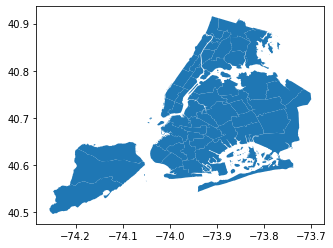

In [54]:
NYC_PUMAs.plot()

Ok looks good. Load in historic districts. [This stackoverflow post](https://gis.stackexchange.com/questions/327197/typeerror-input-geometry-column-must-contain-valid-geometry-objects) was helpful 

In [55]:
from shapely import wkt

In [56]:
hd= gp.read_file('.library/lpc_historic_district_areas/20210712/lpc_historic_district_areas.csv')
hd['the_geom'] = hd['the_geom'].apply(wkt.loads)
hd.set_geometry(col='the_geom', inplace=True, crs='EPSG:4326')

<AxesSubplot:>

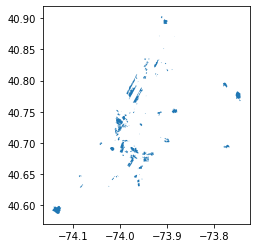

In [57]:
hd= hd.explode(column='the_geom')
hd.set_geometry('the_geom',inplace=True)
hd = hd.reset_index()
hd.plot()

Ok great next do some geospatial analysis. Start only with PUMA 3807 as it has a lot of historic area

In [58]:
import warnings
warnings.filterwarnings("ignore")

In [59]:
def fraction_area_historic(PUMA, hd):
    try:
        gdf = gp.GeoDataFrame(geometry = [PUMA.geometry])
        overlay = gp.overlay( hd, gdf, 'intersection')
        if overlay.empty:
            return 0
        else:
             rv =overlay.area.sum()/PUMA.geometry.area
        return rv
    except Exception as e:
        print(f'broke on {PUMA}')
        print(e)


In [60]:
NYC_PUMAs['fraction_area_historic'] = NYC_PUMAs.apply(fraction_area_historic, axis=1, args=(hd,))

In [61]:
NYC_PUMAs.sort_values('fraction_area_historic', ascending=False)

,geometry,OBJECTID,Shape__Area,Shape__Length,fraction_area_historic
PUMA,,,,,
3810,"MULTIPOLYGON (((-74.01093 40.68450, -74.01193 ...",20,8.102461e+07,122526.203916,0.378907
4004,"POLYGON ((-73.97232 40.70909, -73.97067 40.707...",27,8.668206e+07,73009.762010,0.219019
3806,"POLYGON ((-73.96148 40.79866, -73.96003 40.798...",16,8.849783e+07,47538.308161,0.209455
3805,"MULTIPOLYGON (((-73.95764 40.74841, -73.95749 ...",15,5.522219e+07,54448.948972,0.205994
4006,"POLYGON ((-73.92916 40.68344, -73.92901 40.682...",29,6.186097e+07,42559.173265,0.193027
4005,"POLYGON ((-74.00180 40.69219, -74.00077 40.691...",28,1.145144e+08,95461.245200,0.109452
3802,"POLYGON ((-73.96203 40.81809, -73.96188 40.818...",12,4.690304e+07,37927.770682,0.088717
3803,"POLYGON ((-73.94177 40.80710, -73.94226 40.806...",13,3.984392e+07,38111.565669,0.087804
4003,"POLYGON ((-73.94239 40.70102, -73.94220 40.700...",26,6.403672e+07,44724.500461,0.079128


Superimpose PUMA 3801's historic districts on it to see if 38% looks right

In [69]:
def visualize_overlay(PUMA):
    test_PUMA = NYC_PUMAs.loc[[PUMA]]
    base = test_PUMA.plot(color='green', edgecolor='black')
    overlay = gp.overlay(hd, test_PUMA, 'intersection')
    overlay.plot(ax=base,  color='red');

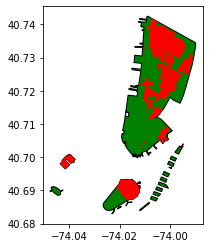

In [71]:
visualize_overlay('3810')

Ok great that looks like about a third to me

From eyeballing map, more than 20% of PUMA 3806 on UWS looks to be historic

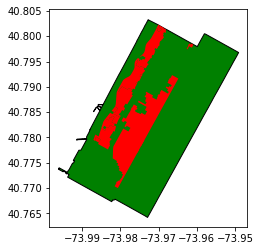

In [72]:
visualize_overlay('3806')

Ah ok the PUMA geography from includes central park. Worth flagging 